In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [2]:
nop.plot_setup()

In [6]:
# Define util functions


def get_name(r, run):
    name = "../testing/@MA4-N2r/output_tmp/" + "out" + "-r" + str(r) + "-run" + str(run)
    return name + ".h5"


def get_mu(a, b):
    data = nop.import_hdf5(get_name(a, b), samples=True)
    return data["mu_nodes"]


def get_sd(a, b):
    data = nop.import_hdf5(get_name(a, b), samples=True)
    return data["sd_nodes"]


def get_kld(a, b):
    data = nop.import_hdf5(get_name(a, b), samples=True)
    return data["kl_divs"]


# Analytical functions for conjugate pairs


def sd_N(sd0, sd_in, N):
    """Returns analytically obtained sd of Normal conjugate pair after N data points with sd=sd_in"""
    return (sd0**-2 + N * sd_in**-2) ** -0.5


def KLD_PPD(mu1, mu2, sd1, sd2):
    """Returns analytically obatined KLD of two univariate Normal distributions"""
    return np.log(sd2 / sd1) + (sd1**2 + (mu1 - mu2) ** 2) / (2 * sd2**2) - 1 / 2


def get_ls(sd_llf):
    ls = ""
    if sd_llf == 1:
        ls = "--"
    elif sd_llf < 1:
        ls = ":"
    else:
        ls = "-"
    return ls

In [7]:
# Define parameter ranges to be used in this analysis
N_nodes = 150
r_arr = np.round(np.concatenate((np.arange(1, 5), np.arange(5, 20.1, 5))), 0)
t_arr = np.arange(1e4, dtype=float)

In [16]:
# Initialize xarray Dataset
tmp_arr = np.empty((len(r_arr), len(t_arr), N_nodes))

ds = xr.Dataset(
    {
        "mu": (("r", "time", "node"), np.empty_like(tmp_arr)),
        "sd": (("r", "time", "node"), np.empty_like(tmp_arr)),
        "kld": (("r", "time", "node"), np.empty_like(tmp_arr)),
    },
    coords={
        "r": r_arr,
        "time": t_arr,
        "node": np.arange(N_nodes),
    },
)
del tmp_arr

# Populate the dataset
for r in r_arr:
    ds.mu.loc[dict(r=r)] = get_mu(r, 0)[:-1]
    ds.sd.loc[dict(r=r)] = get_sd(r, 0)[:-1]
    ds.kld.loc[dict(r=r)] = get_kld(r, 0)[:-1]

ds

<xarray.Dataset> Size: 288MB
Dimensions:  (r: 8, time: 10000, node: 150)
Coordinates:
  * r        (r) float64 64B 1.0 2.0 3.0 4.0 5.0 10.0 15.0 20.0
  * time     (time) float64 80kB 0.0 1.0 2.0 ... 9.997e+03 9.998e+03 9.999e+03
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (r, time, node) float64 96MB 0.0 0.0 0.0 ... 2.281 -14.32 -14.32
    sd       (r, time, node) float64 96MB 10.05 10.05 10.05 ... 1.0 1.0 1.0
    kld      (r, time, node) float64 96MB 1.813 1.813 1.813 ... 102.5 102.6

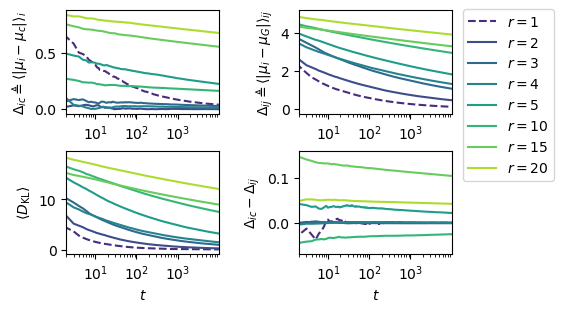

In [24]:
# Look at KLD, Delta_ic, Delta_ij
# (re)def. param.s
r_arr = ds.r.values
time = ds.time.values
# Plot setup
colors = nop.get_colorcycle(len(r_arr))
x = 2
y = 2
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, c * y))
for i in ax.reshape(-1):
    i.set_prop_cycle(color=colors)

for r in r_arr:
    # <|mu_i-mu_x|>
    i, j = 0, 0
    ax[i, j].plot(
        time,
        np.abs(ds.mu.sel(r=r).mean(dim="node")),
        label="$r=$" + str(int(r)),
        ls=get_ls(r),
    )
    # <|mu_i-mu_j|>
    i, j = 0, 1
    ax[i, j].plot(
        time,
        np.abs(ds.mu.sel(r=r) - ds.mu.sel(r=r).mean(dim="node")).mean(dim="node"),
        label="_$r=$" + str(int(r)),
        ls=get_ls(r),
    )
    # <Delta_ic - Delta_ij>
    i, j = 1, 1
    if r != 0:
        ax[i, j].plot(
            time,
            # np.abs(
            (
                np.abs(ds.mu.sel(r=r)).mean(dim="node")
                - np.abs(ds.mu.sel(r=r) - ds.mu.sel(r=r).mean(dim="node")).mean(
                    dim="node"
                )
            ),
            label="_$r=$" + str(int(r)),
            ls=get_ls(r),
        )
    # <KLD>
    i, j = 1, 0
    ax[i, j].plot(
        time,
        ds.kld.sel(r=r).mean(dim="node"),
        label="_$r=$" + str(int(r)),
        ls=get_ls(r),
    )


# Figure cosmetics
for i in ax.reshape(-1):
    i.set_xlim((time[2], time[-1]))
    # i.set_ylim(10**-3, 10**0.5)
    i.set_xscale("log")
#    i.set_yscale("log")

# Labels and stuffs
ax[0, 0].set_ylabel("$\Delta_{ic} \\triangleq \langle |\mu_i-\mu_c|\\rangle_i$")
ax[0, 1].set_ylabel("$\Delta_{ij}\\triangleq\langle |\mu_i-\mu_G|\\rangle_{ij}$")
ax[1, 1].set_ylabel("\n$\Delta_{ic} - \Delta_{ij}$")
ax[1, 0].set_ylabel("$\langle D_\\text{KL} \\rangle$")
ax[1, 0].set_xlabel("$t$")
ax[1, 1].set_xlabel("$t$")


fig.legend(bbox_to_anchor=(1, 1.013), loc=2)